<a href="https://colab.research.google.com/github/Zybreo/Predict-weather-in-AUS/blob/main/Group_project_6100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/weatherAUS_v3.csv')
df1 = pd.read_csv('/content/weather_test .csv')

In [ ]:
missing_values = df.isna()
missing_value_counts1 = df.isna().sum()
missing_values1 = df1.isna()
missing_value_counts2 = df1.isna().sum()
print(missing_value_counts1,missing_value_counts2)

Date                    0
Location                0
MinTemp              1485
MaxTemp              1261
Rainfall             3261
Evaporation         62790
Sunshine            69835
WindGustDir         10326
WindGustSpeed       10263
WindDir9am          10566
WindDir3pm           4228
WindSpeed9am         1767
WindSpeed3pm         3062
Humidity9am          2654
Humidity3pm          4507
Pressure9am         15065
Pressure3pm         15028
Cloud9am            55888
Cloud3pm            59358
Temp9am              1767
Temp3pm              3609
State                3009
On The Coast?           0
Coast                   0
Rain_Last_7_Days      294
Rain_2_Days             0
Rain_3_Days             0
RainTomorrow         3267
dtype: int64 Date                 0
Location             0
MinTemp           3247
MaxTemp           3258
Rainfall           259
Evaporation       9636
Sunshine         10241
WindGustDir        635
WindGustSpeed      634
WindDir9am         716
WindDir3pm         550
WindSp

In [ ]:
print(df.dtypes)
print(df1.dtypes)

Date                 object
Location             object
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir          object
WindGustSpeed       float64
WindDir9am           object
WindDir3pm           object
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
State                object
On The Coast?         int64
Coast                object
Rain_Last_7_Days    float64
Rain_2_Days           int64
Rain_3_Days           int64
RainTomorrow        float64
dtype: object
Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
Wi

In [ ]:
# Fill missing numerical values with the mean
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    df[col].fillna(df[col].mean(), inplace=True)
    if col in df1.columns:
        df1[col].fillna(df1[col].mean(), inplace=True)

# Fill missing categorical values with the mode
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)
    if col in df1.columns:
        df1[col].fillna(df1[col].mode()[0], inplace=True)

# Create dummy variables for 'Location' column
df = pd.get_dummies(df, columns=['Location'], drop_first=True)
df1 = pd.get_dummies(df1, columns=['Location'], drop_first=True)

In [ ]:
# Convert 'RainTomorrow' to an integer type
df['RainTomorrow'] = df['RainTomorrow'].astype(int)

In [ ]:
# Prepare the data for the SVM model
X = df.drop(columns=['Date', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'State', 'Coast', 'RainTomorrow'])
y = df['RainTomorrow']

In [ ]:
# Apply PCA to reduce the number of features
pca = PCA(n_components=10)  # Keep 10 principal components
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
# Train the SVM model with the RBF kernel and reduced features
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train_pca, y_train_pca)

# Make predictions using the trained model
y_pred_pca = svm_model.predict(X_test_pca)

In [ ]:
# Evaluate the model
print(classification_report(y_test_pca, y_pred_pca))
print(confusion_matrix(y_test_pca, y_pred_pca))
print("Accuracy: ", accuracy_score(y_test_pca, y_pred_pca))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     22750
           1       0.77      0.43      0.55      6342

    accuracy                           0.85     29092
   macro avg       0.82      0.70      0.73     29092
weighted avg       0.84      0.85      0.83     29092

[[21938   812]
 [ 3605  2737]]
Accuracy:  0.8481713185755534


In [ ]:
# Calculate the counts of each class in the target variable
class_counts = df['RainTomorrow'].value_counts()

# Calculate the proportions of each class
class_proportions = class_counts / len(df)

# Print the counts and proportions
print("Class Counts:\n", class_counts)
print("\nClass Proportions:\n", class_proportions)

Class Counts:
 0    113583
1     31877
Name: RainTomorrow, dtype: int64

Class Proportions:
 0    0.780854
1    0.219146
Name: RainTomorrow, dtype: float64


In [ ]:
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Define the resampling pipeline
resampling_pipeline = Pipeline(
    [
        ('smote', SMOTE(sampling_strategy=0.5)),
        ('undersample', RandomUnderSampler(sampling_strategy=0.8))
    ]
)

In [ ]:
# Apply the resampling pipeline to the training set
X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train, y_train)

# Train the SVM model with the RBF kernel and resampled data
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train_resampled, y_train_resampled)


SVC(C=1)

In [ ]:
# Make predictions using the trained model
y_pred = svm_model.predict(X_test)

In [ ]:
# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     22750
           1       0.58      0.76      0.66      6342

    accuracy                           0.83     29092
   macro avg       0.76      0.80      0.77     29092
weighted avg       0.85      0.83      0.84     29092

[[19343  3407]
 [ 1549  4793]]
Accuracy:  0.8296438883541867


In [ ]:
# Train a linear SVM model
linear_svm_model = SVC(kernel='linear', C=1)
linear_svm_model.fit(X_train_resampled, y_train_resampled)

SVC(C=1, kernel='linear')

In [ ]:
# Get the feature names from the original dataset
feature_names = df.drop(columns=['Date', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'State', 'Coast', 'RainTomorrow']).columns

# Get the coefficients from the linear SVM model
coef = linear_svm_model.coef_[0]

# Print the feature importances
for i in range(len(feature_names)):
    print(f"{feature_names[i]:<20}: {abs(coef[i]):.5f}")

MinTemp             : 0.04948
MaxTemp             : 0.40619
Rainfall            : 0.14576
Evaporation         : 0.00029
Sunshine            : 0.24944
WindGustSpeed       : 0.62523
WindSpeed9am        : 0.02493
WindSpeed3pm        : 0.17355
Humidity9am         : 0.08551
Humidity3pm         : 0.93376
Pressure9am         : 0.83375
Pressure3pm         : 1.16824
Cloud9am            : 0.00867
Cloud3pm            : 0.21487
Temp9am             : 0.12240
Temp3pm             : 0.27389
On The Coast?       : 0.16714
Rain_Last_7_Days    : 0.07698
Rain_2_Days         : 0.04777
Rain_3_Days         : 0.02330
Location_Albany     : 0.07933
Location_Albury     : 0.01728
Location_AliceSprings: 0.01820
Location_BadgerysCreek: 0.01554
Location_Ballarat   : 0.07542
Location_Bendigo    : 0.00606
Location_Brisbane   : 0.04595
Location_Cairns     : 0.10910
Location_Canberra   : 0.02827
Location_Cobar      : 0.01742
Location_CoffsHarbour: 0.08677
Location_Dartmoor   : 0.02243
Location_Darwin     : 0.13657
Locati

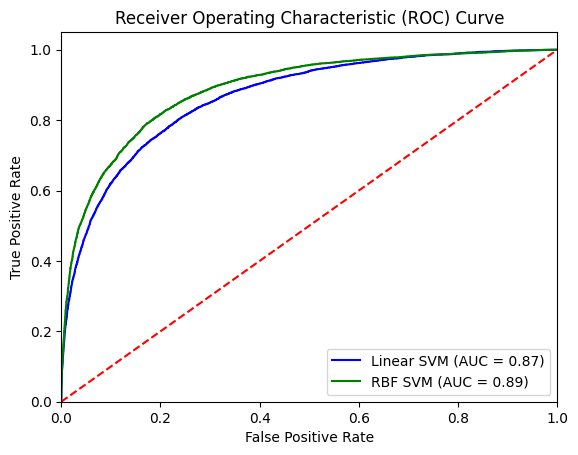

In [ ]:
# Obtain the decision function scores for both models
linear_decision_scores = linear_svm_model.decision_function(X_test)
rbf_decision_scores = svm_model.decision_function(X_test)

# Calculate the ROC curves
fpr_linear, tpr_linear, _ = roc_curve(y_test, linear_decision_scores)
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, rbf_decision_scores)

# Calculate the AUC for both models
auc_linear = auc(fpr_linear, tpr_linear)
auc_rbf = auc(fpr_rbf, tpr_rbf)

# Plot the ROC curves
plt.figure()
plt.plot(fpr_linear, tpr_linear, color='blue', label=f'Linear SVM (AUC = {auc_linear:.2f})')
plt.plot(fpr_rbf, tpr_rbf, color='green', label=f'RBF SVM (AUC = {auc_rbf:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Predict the class labels using the linear SVM model
y_pred_linear = linear_svm_model.predict(X_test)

# Calculate the accuracy score
accuracy_linear = accuracy_score(y_test, y_pred_linear)

# Calculate the confusion matrix
confusion_matrix_linear = confusion_matrix(y_test, y_pred_linear)

# Print the accuracy score, confusion matrix, and classification report
print("Accuracy (Linear SVM):", accuracy_linear)
print("\nConfusion Matrix (Linear SVM):\n", confusion_matrix_linear)
print("\nClassification Report (Linear SVM):\n", classification_report(y_test, y_pred_linear))

Accuracy (Linear SVM): 0.809225904028599

Confusion Matrix (Linear SVM):
 [[18922  3828]
 [ 1722  4620]]

Classification Report (Linear SVM):
               precision    recall  f1-score   support

           0       0.92      0.83      0.87     22750
           1       0.55      0.73      0.62      6342

    accuracy                           0.81     29092
   macro avg       0.73      0.78      0.75     29092
weighted avg       0.84      0.81      0.82     29092

